# Practical Applications for sWeights Paper 

These studies show a few different ways of computing the sweights. We use a ROOT free implementation in python but also have some RooFit style implementations which are commonly used in HEP.

We take a model in 2D which has mass and lifetime. The signal is peaking (Gaussian) in mass and flat (Exponential) in decay time. The background has the opposite. 

## Visualising the PDFs

First we will set some truth values for parameters, construct the PDFs and plot them

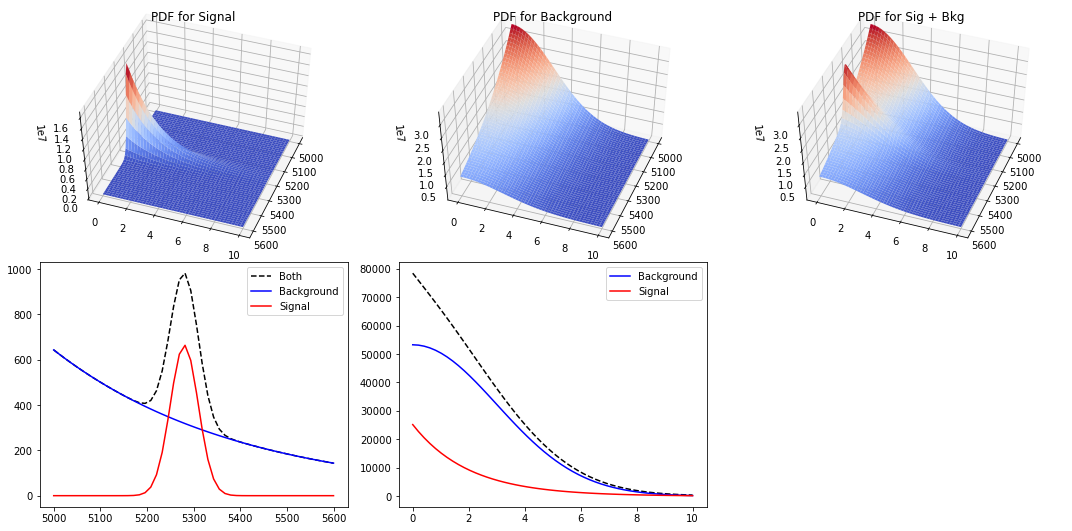

In [1]:
import numpy as np
from scipy.stats import norm, expon
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm

np.random.seed(1)  # fix seed

# true parameters for signal and background
truth_n_sig = 50000
truth_n_bkg = 200000

# signal mass gauss:(mean, sigma)
truth_sig_m = (5280, 30)
# background mass expo:(loc, scale)
truth_bkg_m = (5000,400,)
# signal time expo:(loc, scale)
truth_sig_t = (0, 2.0,)
# background time gauss:(mean, sigma)
truth_bkg_t = (0., 3.0)

# make the pdfs
sig_pdf_mass = norm(*truth_sig_m)
bkg_pdf_mass = expon(*truth_bkg_m)
sig_pdf_time = expon(*truth_sig_t)
bkg_pdf_time = norm(*truth_bkg_t)

# plot the pdfs
mrange = (5000,5600)
trange = (0,10)
mass = np.linspace(*mrange)
time = np.linspace(*trange)

# get the normalisation for the range
sig_norm_mass = np.diff(sig_pdf_mass.cdf(mrange))
bkg_norm_mass = np.diff(bkg_pdf_mass.cdf(mrange))
sig_norm_time = np.diff(sig_pdf_time.cdf(trange))
bkg_norm_time = np.diff(bkg_pdf_time.cdf(trange))

# make a grid for plots
fig = plt.figure(figsize=(15,7.5))
gs = gridspec.GridSpec(2, 3)

# now make the 2D plots
x, y = np.meshgrid( mass, time )
zsig = truth_n_sig*sig_pdf_mass.pdf(x)/sig_norm_mass * truth_n_sig*sig_pdf_time.pdf(y)/sig_norm_time
zbkg = truth_n_bkg*bkg_pdf_mass.pdf(x)/bkg_norm_mass * truth_n_bkg*bkg_pdf_time.pdf(y)/bkg_norm_time
ztot = zsig + zbkg

ax   = fig.add_subplot(gs[0], projection='3d')
ax.plot_surface(x,y,zsig, cmap=cm.coolwarm)
ax.set_title('PDF for Signal')
ax.view_init(50,20)

ax   = fig.add_subplot(gs[1], projection='3d')
ax.plot_surface(x,y,zbkg, cmap=cm.coolwarm)
ax.set_title('PDF for Background')
ax.view_init(50,20)

ax   = fig.add_subplot(gs[2], projection='3d')
ax.plot_surface(x,y,zbkg+zsig, cmap=cm.coolwarm)
ax.set_title('PDF for Sig + Bkg')
ax.view_init(50,20)

# and the 1D plots
ax = fig.add_subplot(gs[3] )
ax.plot( mass, truth_n_sig*sig_pdf_mass.pdf(mass)/sig_norm_mass + truth_n_bkg*bkg_pdf_mass.pdf(mass)/bkg_norm_mass , 'k--', label='Both' )
ax.plot( mass, truth_n_bkg*bkg_pdf_mass.pdf(mass)/bkg_norm_mass, 'b-' , label='Background')
ax.plot( mass, truth_n_sig*sig_pdf_mass.pdf(mass)/sig_norm_mass, 'r-' , label='Signal' )
ax.legend()

ax = fig.add_subplot(gs[4])
ax.plot( time, truth_n_sig*sig_pdf_time.pdf(time)/sig_norm_time + truth_n_bkg*bkg_pdf_time.pdf(time)/bkg_norm_time, 'k--')
ax.plot( time, truth_n_bkg*bkg_pdf_time.pdf(time)/bkg_norm_time, 'b-' , label='Background')
ax.plot( time, truth_n_sig*sig_pdf_time.pdf(time)/sig_norm_time, 'r-' , label='Signal')
ax.legend()

fig.tight_layout()



## Generate some toy data

Use these PDFs to generate a toy dataset which we then visualise with some plots

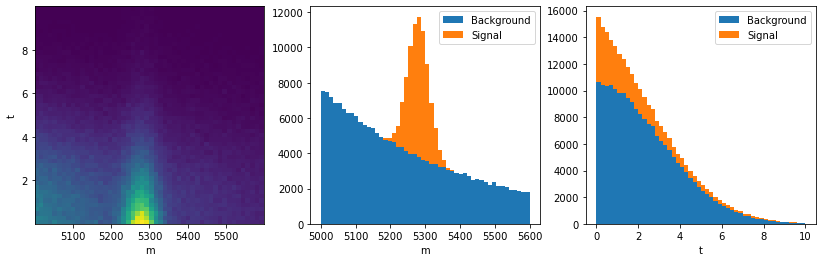

In [2]:
## generate some toy data
truth_n_tot = truth_n_bkg + truth_n_sig
data = np.empty( (truth_n_tot,2) )

# fill sig vals
nsig = 0
while nsig < truth_n_sig:
    mval = sig_pdf_mass.rvs(1)
    tval = sig_pdf_time.rvs(1)
    if mval > mrange[1] or mval < mrange[0] or tval > trange[1] or tval < trange[0]: continue
    data[nsig,0] = mval
    data[nsig,1] = tval
    nsig += 1
    
# fill bkg vals
nbkg = 0
while nbkg < truth_n_bkg:
    mval = bkg_pdf_mass.rvs(1)
    tval = bkg_pdf_time.rvs(1)
    if mval > mrange[1] or mval < mrange[0] or tval > trange[1] or tval < trange[0]: continue
    data[nsig+nbkg,0] = mval
    data[nsig+nbkg,1] = tval
    nbkg += 1
    
# check events are all in range 
subs = ( mrange[0] < data[:,0] ) & ( mrange[1] > data[:,0] ) & ( trange[0] < data[:,1] ) & ( trange[1] > data[:,1] )
assert( len(subs) == len(data) )

# now plot the generated samples
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist2d(data[:,0], data[:,1], bins=(50, 50))
ax[0].set_xlabel("m")
ax[0].set_ylabel("t")
ax[1].hist((data[truth_n_sig:,0], data[:truth_n_sig,0]), bins=50, stacked=True, label=("Background", "Signal"))
ax[1].set_xlabel("m")
ax[1].legend()
ax[2].hist((data[truth_n_sig:,1], data[:truth_n_sig,1]), bins=50, stacked=True, label=("Background", "Signal"))
ax[2].set_xlabel("t")
ax[2].legend();


## Fit the data

Fit the toy back in the mass variable

In [3]:
from iminuit import Minuit

# extended likelihood
def nll(n_sig, n_bkg, mu, sigma, lambd):
    s = norm(mu, sigma)
    b = expon(5000, lambd)
    # normalisation factors are needed for pdfs, since x range is restricted
    sn = np.diff(s.cdf(mrange))
    bn = np.diff(b.cdf(mrange))
    no = n_sig + n_bkg
    return no - np.sum(np.log(s.pdf(data[:,0]) / sn * n_sig + b.pdf(data[:,0]) / bn * n_bkg))


mi = Minuit(nll,
            n_sig=truth_n_sig, n_bkg=truth_n_bkg,
            mu=truth_sig_m[0], sigma=truth_sig_m[1], lambd=truth_bkg_m[1],
            errordef=Minuit.LIKELIHOOD,
            pedantic=False)

display(mi.migrad())
mi.hesse()

par = mi.np_values()
cov = mi.np_covariance()

------------------------------------------------------------------
| FCN = -1.293E+06              |     Ncalls=112 (112 total)     |
| EDM = 7.04E-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | n_sig |  0.494E5  |  0.004E5  |            |            |         |         |       |
| 1 | n_bkg |  2.006E5  |  0.005E5  |            |            |         |         |       |
| 2 | mu    |  0.528E4  |  0.000E4  |            |            |         |         |       |
| 3 | sigma |   29.74   |   0.21    |            |            |         |         |       |
| 4 | lambd |   402.5   |    2.3    |            |            |         |         |       |
-------------------------------------------------------------------------------------------

### Visualise the fitted model

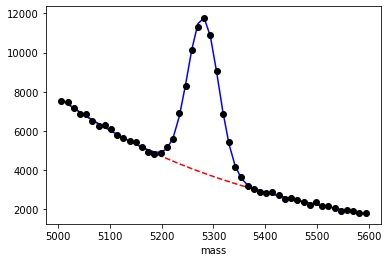

In [4]:
# visualise the fitted model
def mass_pdf(m, bonly=False, sonly=False):
    n_sig, n_bkg, mu, sigma, lambd = par
    spdf = norm(mu, sigma)
    bpdf = expon(5000, lambd)
    
    sn = np.diff(spdf.cdf(mrange))
    bn = np.diff(bpdf.cdf(mrange))
    
    if sonly: return n_sig * spdf.pdf(m) / sn
    if bonly: return n_bkg * bpdf.pdf(m) / bn
    return n_sig * spdf.pdf(m) / sn + n_bkg * bpdf.pdf(m) / bn

# bin data
w, xe = np.histogram(data[:,0], bins=50, range=mrange)
cx = 0.5 * (xe[1:] + xe[:-1])
# bin width to normalise mass_pdf for plotting
mass_pdfnorm = (mrange[1]-mrange[0])/50 

plt.errorbar( cx, w, w**0.5, fmt='ko')
plt.plot( cx, mass_pdfnorm*mass_pdf(cx,bonly=True), 'r--')
plt.plot( cx, mass_pdfnorm*mass_pdf(cx), 'b-')
plt.xlabel('mass')
plt.savefig('figs/mass_fit.pdf')


## Now compute the sweights

We have six different methods that we use here (and they all give slightly different results). Although not sure exactly why:

- "summation" method. Compute W-matrix and then solve for alphas (which is similar to the covariance matrix)
- "integration" method. The smooth version of above
- "refit" method. Takes the alpha matrix directly as the covariance matrix when refit with all paramters aside from yields frozen
- "subhess" method. Takes the alpha matrix as the elements of the covariance matrix associated to yields from a full fit (i.e. with non-yield parameters not frozen)
- "tsplot" method. Implements the ROOT TSPlot calculation. Expected this to give the same results as "summation"
- "roofit" method. Implements the RooStats SPlot calculation. Expected this to give the same results as "summation"

Welcome to JupyROOT 6.18/04
Initialising SWeighter with the summation method:
    W-matrix:
	[[1.13641031e-05 2.18448006e-06]
	 [2.18448006e-06 4.44759881e-06]]
    alpha-matrix:
	[[ 97170.63231425 -47726.27156987]
	 [-47726.27156987 248281.63124674]]
    Integral of w*pdf matrix (should be close to the identity):
	[[ 1.00007111e+00 -1.59854439e-05]
	 [-6.85684403e-05  1.00001466e+00]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        | 49444.0508 | 49444.0508 |     0.00% |
	  1        | 200555.8094 | 200555.8094 |     0.00% |
Initialising SWeighter with the integration method:
    W-matrix:
	[[1.13647614e-05 2.18433043e-06]
	 [2.18433043e-06 4.44762911e-06]]
    alpha-matrix:
	[[ 97162.96043712 -47718.90960036]
	 [-47718.90960036 248274.71901   ]]
    Integral of w*pdf matrix (should be close to the identity):
	[[ 1.00000000e+00 -4.87327817e-11]
	 [-2.21497543e-11  1.0000

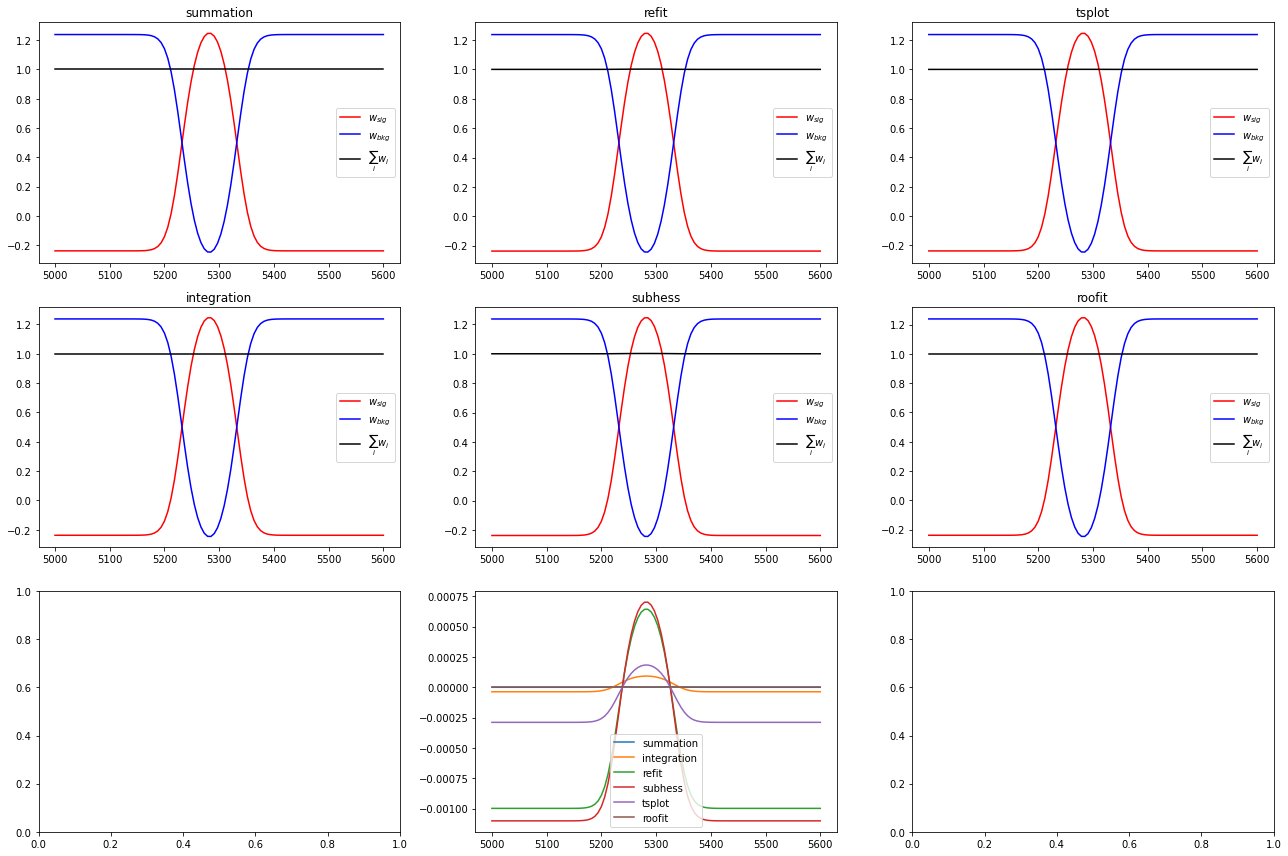

In [5]:
from MySWeightClass import SWeight

# set up the numpy/scipy format of pdfs and yields
pdfs = [ norm( mi.values['mu'], mi.values['sigma'] ) ,
         expon( 5000, mi.values['lambd'] )
       ]
yields = [ mi.values['n_sig'], mi.values['n_bkg'] ]

# set up the roofit format of pdfs and yields
import ROOT as r
rf_mass = r.RooRealVar('mass','mass',*mrange)
rf_mean = r.RooRealVar('mean','mean', mi.values['mu'] )
rf_sigma = r.RooRealVar('sigma','sigma', mi.values['sigma'] )
rf_lambd = r.RooRealVar('lambd','lambd', -1./mi.values['lambd'] )
rfpdfs = [ r.RooGaussian( 'gaus','gaus',rf_mass, rf_mean, rf_sigma ), r.RooExponential( 'expo','expo',rf_mass,rf_lambd) ]

sweighters = []

for i, meth in enumerate(['summation','integration','refit','subhess','tsplot','roofit']):
  alphas = None
  if meth=='subhess':
    inv_cov = np.linalg.inv(cov)
    alphas = np.linalg.inv( inv_cov[:2, :2] )

  if meth=='roofit':
    sw = SWeight( data[:,0], pdfs=rfpdfs, yields=yields, discvarranges=(mrange,), method=meth, compnames=('sig','bkg'), alphas=alphas, rfobs=[rf_mass] )
  else:
    sw = SWeight( data[:,0], pdfs=pdfs, yields=yields, discvarranges=(mrange,), method=meth, compnames=('sig','bkg'), alphas=alphas )

  sweighters.append(sw)

# plot the weight distributions
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

for i, sw in enumerate(sweighters):

  plax = ax[ i%2, int(i/2) ]
  sw.makeWeightPlot(plax)
  plax.set_title(sw.method)

  x = np.linspace(*mrange,100)
  ax[2,1].plot( x, sweighters[0].getWeight(0,x) - sw.getWeight(0, x), label=sw.method )

ax[2,1].legend()
fig.tight_layout()
fig.savefig('figs/sweights.pdf')


## Now fit back the weighted data to get an estimate of the signal only parameter

This likelihood definition will get the error wrong (because it doesn't incorporate any correction for weights), it is possibly also biased somehow?

All the weights are very similar (some small differences) and they all return similar values when fittiing back the slope of the signal time distribution to the sweighred data, $\lambda \approx 1.99$. Using the full 2D fit also gives $\lambda = 1.99$ and things look good by eye. This high stats test seems to show the method work nicely (at least asymptotically). We should make some statements about how it performs in lower stats examples.

Fitted back lambd = 1.9911919549 (estimated 1.9248471699) for method summation
Fitted back lambd = 1.9912281511 (estimated 1.9248772787) for method integration
Fitted back lambd = 1.9927939313 (estimated 1.9262274102) for method refit
Fitted back lambd = 1.9929704267 (estimated 1.9263717112) for method subhess
Fitted back lambd = 1.9915940264 (estimated 1.9252477135) for method tsplot
Fitted back lambd = 1.9911900358 (estimated 1.9248455736) for method roofit


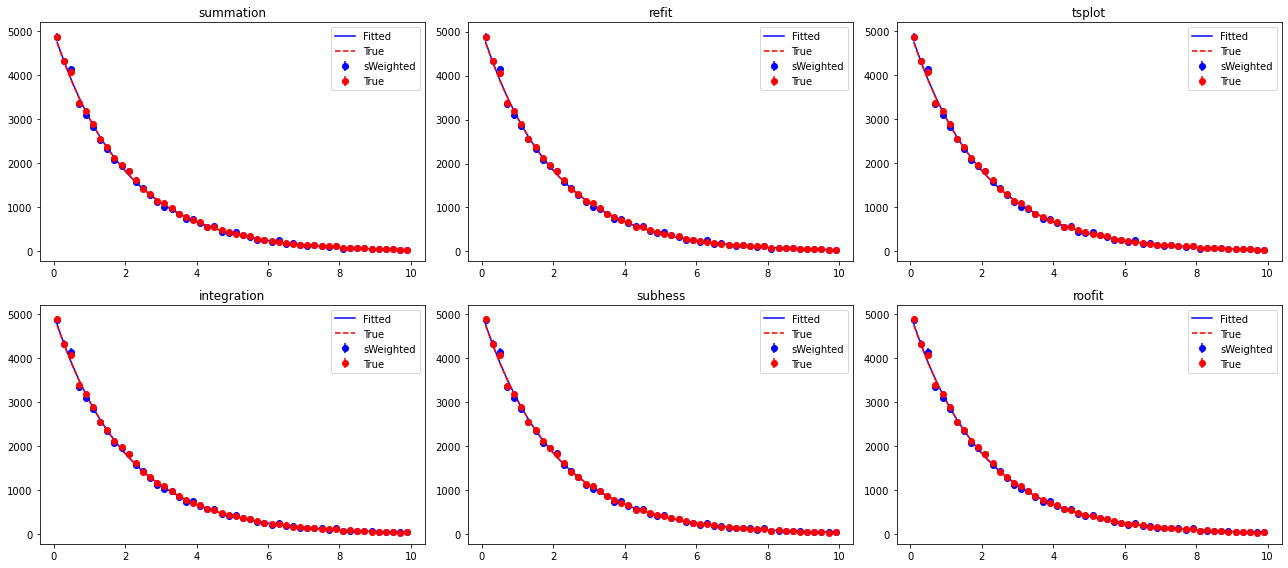

In [6]:
## now fit back the weighted data to get the true parameter
import boost_histogram as bh

# make a histogram of the true values
nbins = 50
thist = bh.Histogram( bh.axis.Regular(nbins,*trange) )
thist.fill( data[:truth_n_sig,1] )

global wfunc

def expnll(lambd):
    global wfunc
    b = expon(0, lambd)
    # normalisation factors are needed for time_pdfs, since x range is restricted
    bn = np.diff(b.cdf(trange))
    return -np.sum( wfunc(0,data[:,0]) * np.log( b.pdf(data[:,1]) / bn ) )

def timepdf(lambd, x):
    b = expon(0,lambd)
    bn = np.diff(b.cdf(trange))
    return b.pdf(x) / bn

fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, sw in enumerate(sweighters):

    wfunc = sw.getWeight

    mi = Minuit( expnll, lambd=truth_sig_t[1], limit_lambd=(1,3), errordef=Minuit.LIKELIHOOD, pedantic=False )
    mi.migrad()
    mi.hesse()
    fitted_value = mi.values['lambd']
    estima_value = np.sum( data[:,1]*sw.getWeight(0,data[:,0])) / np.sum( sw.getWeight(0, data[:,0]))
    print( 'Fitted back lambd = {:12.10f}'.format(fitted_value), '(estimated {:12.10f})'.format(estima_value), 'for method', sw.method )

    # make a weighted histogram for time values with sweights
    nbins = 50
    whist = bh.Histogram( bh.axis.Regular(nbins,*trange), storage=bh.storage.Weight())
    whist.fill( data[:,1], weight=sw.getWeight(0,data[:,0]) )

    plax = ax[ i%2, int(i/2) ]
    plax.errorbar( whist.axes[0].centers, whist.view().value, whist.view().variance**0.5, fmt='bo', label='sWeighted' )
    plax.errorbar( thist.axes[0].centers, thist.view(), thist.view()**0.5, fmt='ro', label='True' )
    time_pdfnorm = (trange[1]-trange[0])/nbins
    plax.plot( whist.axes[0].centers, np.sum(sw.getWeight(0,data[:,0]))*time_pdfnorm*timepdf(fitted_value, whist.axes[0].centers), 'b-' , label='Fitted')
    plax.plot( whist.axes[0].centers, np.sum(sw.getWeight(0,data[:,0]))*time_pdfnorm*timepdf(truth_sig_t[1], whist.axes[0].centers), 'r--', label='True' )
    plax.set_title( sw.method )
    plax.legend()

fig.tight_layout()
fig.savefig('figs/time_fits.pdf')


## Save the output in a pandas DF

In [7]:
### SAVE THE RESULTS ###
import pandas as pd
df = pd.DataFrame(data, columns=['mass','time'])
for sw in sweighters:
  for icomp in range(sw.ncomps):
    df['w%s_%s'%(sw.compnames[icomp],sw.method)] = sw.getWeight(icomp, data[:,0])
df.to_pickle("sweights.pkl")

#print(df)


## Have a look to see what would have happened if we'd fitted in 2D

Should we be concerned that this value is not really the same as the one obtained by fitting the sWeighted data above?

In [8]:
# extended likelihood
def nll2d(n_sig, n_bkg, mu, sigma, lambd, slambdt, bmut, bsigmat):
    sm = norm(mu, sigma)
    bm = expon(5000, lambd)
    st = expon(0,slambdt)
    bt = norm(bmut,bsigmat)
    
    # normalisation factors are needed for pdfs, since x range is restricted
    smn = np.diff(sm.cdf(mrange))
    bmn = np.diff(bm.cdf(mrange))
    stn = np.diff(st.cdf(trange))
    btn = np.diff(bt.cdf(trange))
    no = n_sig + n_bkg
    return no - np.sum(np.log(sm.pdf(data[:,0]) / smn * st.pdf(data[:,1]) / stn * n_sig 
                            + bm.pdf(data[:,0]) / bmn * bt.pdf(data[:,1]) / btn * n_bkg))


mi = Minuit(nll2d,
            n_sig=truth_n_sig, n_bkg=truth_n_bkg,
            mu=truth_sig_m[0], sigma=truth_sig_m[1], lambd=truth_bkg_m[1],
            slambdt=truth_sig_t[1], bmut=truth_bkg_t[0], bsigmat=truth_bkg_t[1],
            errordef=Minuit.LIKELIHOOD,
            pedantic=False)

display(mi.migrad())
mi.hesse()
print( mi.values['slambdt'])

------------------------------------------------------------------
| FCN = -8.453E+05              |     Ncalls=168 (168 total)     |
| EDM = 2.34E-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
---------------------------------------------------------------------------------------------
|   | Name    |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------
| 0 | n_sig   |  0.495E5  |  0.003E5  |            |            |         |         |       |
| 1 | n_bkg   |  2.005E5  |  0.005E5  |            |            |         |         |       |
| 2 | mu      |  0.528E4  |  0.000E4  |            |            |         |         |       |
| 3 | sigma   |   29.78   |   0.21    |            |            |         |         |       |
| 4 | lambd   |   402.5   |    2.3    |            |            |         |         |       |
| 5 | slambdt |   1.988   |   0.014   |            |            |         |         |       |
| 6 | bmut    |   0.09    |   0.03    |            |            |         |         |       |
| 7 | bsigmat |   2.964   |   0.015   |            |            |         |         |       |
---------------------------------------------------------------------------------------------

1.9881425003090616
